# Variance reduction: Method of Control variates

### 1.Review on options pricing with exact simulations

In [27]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

**A brief review on exact simulation**

To better motivated, we will use MC examples on the calculation of EC, AAC, GAC prices.
We first recall exact simulation on their calculations. 

In [28]:
#define a function of BM path generator
#generate $\hat W(t_i)$, where $t_i = i T/n$ for $i = 0, 1, ..., n$

def BM_gen(T1, T2, n):  #para: start time, end time, and the mesh number 
    t = np.linspace(T1, T2, num = n+1) #init mesh
    W = np.zeros(n+1) #init BM
    #Run (3.2)
    for i in range(n):
        W[i+1] = W[i] + 1./np.sqrt(n) * np.random.normal()
        
    return t, W
    

We simulate payoffs for the following different types: 

Stock price, European call, Geometric asisan call, Arithmetic asian call 

we use $t = [t_1, t_2, \ldots t_n]$ for tenuor, where $t_i = \frac{(i-1) T}{n-1}$ is uniform mesh of $[0,T]$.

The payoff of the AAC can be expressed by the formula 

$$max(0,\frac{1}{n} \sum_{i=1}^{n} S_i - K),$$

and the payoff of the GAC can be expressed by the formula

$$max(0, \sqrt[n]{S_0 S_1 \cdots S_n} - K),$$

and we can convert the above formula to 

$$max(0, \frac{1}{n} \sum_{i=1}^{n} ln S_i - ln K).$$

In [29]:
#Generate payoffs for the following different types: Stock price, European call, Arithmetic asian call, Geometric asisan call, 

def CallPayoffs(S0, r, sigma, K, T, n):
    [t, W] = BM_gen(0, T, n-1) #BM path
    S = S0 * np.exp((r - sigma^2/2.) * t + sigma * W) #stock path
    Stk_Payoff = S[-1] #stock terminal payoff
    EC_Payoff = np.max([0, S[-1] - K]) #EC payoff
    AAC_Payoff = np.max([0, np.mean(S) - K]) #AAC payoff
    GAC_Payoff = np.max([0, np.exp(np.mean(np.log(S))) - K])
    return([Stk_Payoff, EC_Payoff, AAC_Payoff, GAC_Payoff])

**Ex** An example is given below. Compare price of EC, AAC, GAC. The numerical example shows that $EC > AAC >GAC$. Is it always true?

In [30]:
#An example is given here
S0 = 100.0
K = 110.0
r=0.0475
sigma = 0.20
T = 1.
delta = 0.
n = 5
t = np.linspace(0., T, n)


In [31]:
#calculate stk, EC, AAC, GAC prices
simN = 1000
payoffs =  np.zeros(4)
for i in range(simN):
    payoffs = payoffs + CallPayoffs(S0, r, sigma, K, T, n)
print('stk, EC, AAC, GAC are ' + str(np.exp(-r*T)*payoffs/simN))

stk, EC, AAC, GAC are [ 99.54308059   5.67183192   1.6991868    1.52431078]


In [32]:
a = CallPayoffs(S0, r, sigma, K, T, n)
print(a)
np.zeros(4)

[95.676955248429181, 0.0, 0.0, 0.0]


array([ 0.,  0.,  0.,  0.])

In [33]:
simN = 1000
payoff_arrays = np.zeros([4,simN])
for i in range(simN):
    payoff_arrays[:,i] = CallPayoffs(S0, r, sigma, K, T, n)


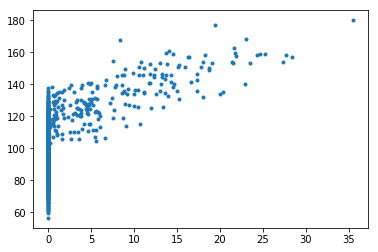

In [34]:
#plot AAC vs Stk
plt.plot(payoff_arrays[2,:], payoff_arrays[0,:], '.');

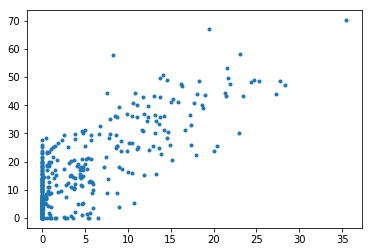

In [35]:
#plot AAC vs EC
plt.plot(payoff_arrays[2,:], payoff_arrays[1,:], '.');

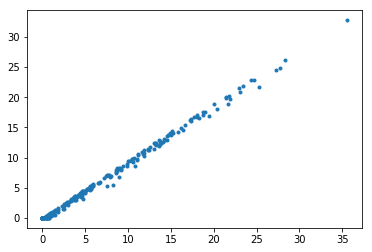

In [36]:
#plot AAC vs GAC
plt.plot(payoff_arrays[2,:], payoff_arrays[3,:], '.');

**Conclusion**
AAC and GAC payoffs are strongly corrlated, since the graph is slimest.

### 2.Method on control variates
**Refer to [Gla03]**

Let $X\sim \phi$ and $\mathbb E[X] = \mu$ and $SD(X) = \sigma>0$, where $\mu$ and $\sigma$ are unknowns. 

Our goeal is to eistmiate $\mu$.

In crude MC, suppose computer can generate iid replicates $(X_i: i = 1, 2, ...)$, then we take the average of the first $N$ replicates as its estimate:
$$\mu_N  = \frac 1 N \sum_{i=1}^N X_i \to \mu, \hbox{ as } N\to \infty.$$
The above convergence is guranteed by LLN. In other words, if we set the error as
$$e_N = \mu_N - \mu,$$
we have $e_N \to 0$ as $N\to \infty$, which is the most desired property of the estimator.

Another desired property is $L^2$ convergence, i.e. 
$$Var(e_N) = \mathbb E e_N^2 \to 0, \hbox{ as } N\to \infty.$$
This property holds due to the following $L^2$ error estimation
$$\mathbb E e_N^2 =  \sigma^2/N.$$
Indeed, by CLT, we also have 
$$e_N \Rightarrow \mathcal{N}(0, \sigma/\sqrt{N}).$$

**Desired properties of the estimator**

- (unbiasedness) $\lim_N e_N = 0$ 
- (efficiency) $Var(e_N)$ as small as possible.

The **method of control variates** is to estimate $\mu = \mathbb E[X]$ with smaller variance of error term, if the computer can generates iid pairs of random variables $(X_i, Y_i)$, where $X_i$ is replicate of $X$ and $Y_i$ is some additional observation.
In this case, an estimator given by
$$\mu_N(b) = \frac 1 N \sum_{i=1}^N (X_i - b(Y_i - \mathbb E[Y]))$$
shall gives unbiased estimator of $\mu$ for any number $b$. The key fact is that
$$b^* = \frac{Cov(X,Y)}{Var(Y)} = \frac{\mathbb E[(X- \mathbb E[X])(Y - \mathbb E[Y])]}{\mathbb E[(Y - \mathbb E[Y])^2]}.$$
minimize the variance of $\mu_N(b)$, and thus the variance of $e_N(b) = \mu_N(b) - \mu$. In practice, $b^*$ is replaced by its estimate
$$b_N = \frac{\sum_{i=1}^N (X_i - \mu_N(X))(Y_i - \mu_N(Y))}{\sum_{i=1}^N (Y_i - \mu_N(Y))^2} $$

The choice of control variates depend on 
- Availability of $\mathbb E[Y]$;
- Correlation between $X$ and $Y$ (the stronger the better);

**ex** __Compute AAC with GAC as its control variate with the following parameters.__


In [37]:
#An example is given here
S0 = 100.0
K = 110.0
r=0.0475
sigma = 0.20
T = 1.
delta = 0.
n = 5
t = np.linspace(0., T, n)


[Code] Let $X$ and $Y$ be the discounted payoff of AAC and GAC.
1. Compute $\mathbb E [Y]$ explicitly;
2. Generate $(X_i, Y_i: i = 1, 2, ..., N)$
3. Compute sequentially
$$\mu_N(X), \mu_N(Y), b_N, \mu_N(b_N).$$

##### (1)Find GAC price from explicit formula. See previous notes on "BSPrice"

In [38]:
#Black and Scholes
def d1(S0, K, r, sigma, T, delta):
    return (np.log(S0/K) + (r - delta + sigma**2 / 2) * T)/(sigma * np.sqrt(T))

def d2(S0, K, r, sigma, T, delta):
    return (np.log(S0 / K) + (r -delta - sigma**2 / 2) * T) / (sigma * np.sqrt(T))

#BS formula for Call (type = "C") and Put (type = "P")
def BlackScholes(type,S0, K, r, sigma, T, delta):
    if type=="C":
        return S0 * np.exp(-delta*T) * ss.norm.cdf(d1(S0, K, r, sigma, T, delta)) - K * np.exp(-r * T) * ss.norm.cdf(d2(S0, K, r, sigma, T, delta))
    else:
       return K * np.exp(-r * T) * ss.norm.cdf(-d2(S0, K, r, sigma, T, delta)) - S0  * np.exp(-delta*T) * ss.norm.cdf(-d1(S0, K, r, sigma, T, delta))

#tt represents tenors with adding t_0 = 0.
tt = np.append([0], t)

tmp = 0.
for j in range(n):
    tmp = tmp + np.power(n-j, 2) * (tt[j+1] - tt[j])
sigma_hat = np.power(tmp/T, .5)*sigma/n


mu = r - delta - sigma^2/2.
delta_hat = r - sigma_hat**2/2. - np.sum(tt)*mu/n/T

#Implementation
GAC = BlackScholes('C',S0, K, r, sigma_hat, T, delta_hat)
print('Geometric asian call is:' + str(GAC))

Geometric asian call is:1.60716472743


##### (2) Generate datum $(X_i, Y_i: i = 1, ...,N)$

In [39]:
simN = 100

payoff_arrays = np.zeros([2,simN]) #store payffs in the order of AAC, GAC
for i in range(simN):
    payoff_arrays[:,i] = CallPayoffs(S0, r, sigma, K, T, n)[2:4]
X = np.exp(-r*T)*payoff_arrays[0,:]
Y = np.exp(-r*T)* payoff_arrays[1,:]


##### (3)Compute from datum

In [40]:
#compute mu_N_X and mu_N_Y
mu_N_X = np.mean(X)
mu_N_Y = np.mean(Y)
#compute b_N
xy_cov = np.cov([X, Y])
b_N = xy_cov[0,1]/xy_cov[1,1]
AAC = np.mean(X - b_N * Y) + b_N * GAC


In [41]:
print('AAC is ' + str(AAC))

AAC is 1.77351086861


Now let's see how it improves MC. Since we do not have precise price for AAC, we will use large number of simulation on crude MC for its replacement.

In [42]:

simN = 100 #numer of simulations for each estimate     
payoff_arrays = np.zeros(simN) #store payffs in the order of AAC, GAC

for i in range(simN):
    payoff_arrays[i] = CallPayoffs(S0, r, sigma, K, T, n)[2]
X = np.exp(-r*T)*payoff_arrays

AAC_crude_MC = np.mean(X)
print('AAC by crude MC is ' + str(AAC_crude_MC))

AAC by crude MC is 2.24594396136


In [43]:

simN = 100000 #numer of simulations for each estimate     
payoff_arrays = np.zeros(simN) #store payffs in the order of AAC, GAC

for i in range(simN):
    payoff_arrays[i] = CallPayoffs(S0, r, sigma, K, T, n)[2]
X = np.exp(-r*T)*payoff_arrays

AAC_semi_precise = np.mean(X)
print('AAC for semi precise value is ' + str(AAC_semi_precise))

AAC for semi precise value is 1.7779920737


We can see that as the number of simulation increase, the AAC simulated by the ordinary Monte Carlo can goes closely to the value we get by adjust with GAC. So it is more precise than the ordinary MC.